# Figure 3

In [1]:
# import copy
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import warnings

import nelpy as nel
import nelpy.plotting as npl

from nelpy import hmmutils

# Set default figure aesthetics
npl.setup(font_scale=1.0)

%matplotlib inline

warnings.filterwarnings("ignore")

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
datadirs = ['data/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

if load_from_nel:
    jar = nel.load_pkl(fileroot + 'fig1.nel')
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar

# Decode some RUN data to the state space

In [3]:
session, segment = '16-40-19', 'short'
PBEs = aux_data[session][segment]['PBEs_noIN']
pos = exp_data[session]['pos1d']

In [4]:
sigma=0.3
ds_run = 0.1 # 100 ms bins for RUN data
ds_50ms = 0.05
st_run_no_mua = exp_data[session]['spikes_noIN'][1][exp_data[session]['run_epochs']][~exp_data[session]['mua_epochs']]
st_run_no_mua = st_run_no_mua._unit_subset(aux_data[session][segment]['PBEs_noIN'].unit_ids)
bst_run_no_mua = st_run_no_mua.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=round(ds_run/ds_50ms))

hmm = nel.hmmutils.PoissonHMM(n_components=30)
hmm.fit(PBEs)

nelpy.PoissonHMM(init_params='stm', n_components=30, n_iter=50, params='stm',
      random_state=None, verbose=False); fit=True, fit_ext=False

In [5]:
xpos = pos.asarray(at=bst_run_no_mua.centers).yvals

ext_nx=124
x0=0; xl=310;
xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_run_no_mua, ext=ext_x, n_extern=ext_nx)

new_order = hmm.get_state_order(method='mean')
hmm.reorder_states(new_order)

In [6]:
example1 = (1470,1550)
example2 = (1805,1890)

(1470, 1550)

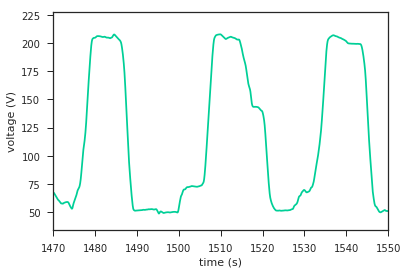

In [7]:
npl.plot(pos[1]); ax = plt.gca()
ax.set_xlim(example1)

(1805, 1890)

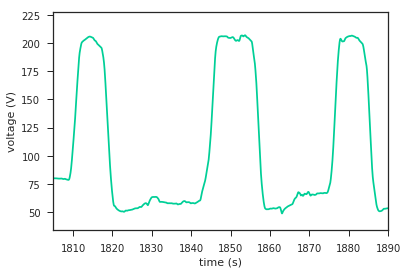

In [8]:
npl.plot(pos[1]); ax = plt.gca()
ax.set_xlim(example2)

In [9]:
example1_epoch = nel.EpochArray(example1)
st_example1 = st_run_no_mua[example1_epoch]
sigma = 0.3 # 300 ms spike smoothing
bst_example1 = st_example1.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=round(ds_run/ds_50ms))
pos_example1 = pos[example1_epoch][st_run_no_mua.support]

In [10]:
example2_epoch = nel.EpochArray(example2)
st_example2 = st_run_no_mua[example2_epoch]
sigma = 0.3 # 300 ms spike smoothing
bst_example2 = st_example2.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=round(ds_run/ds_50ms))
pos_example2 = pos[example2_epoch][st_run_no_mua.support]

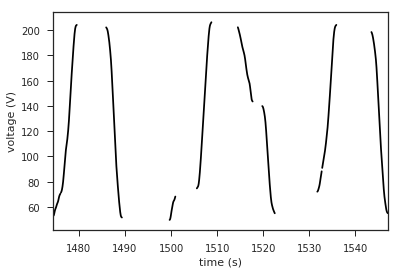

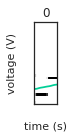

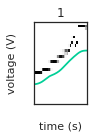

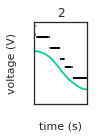

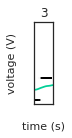

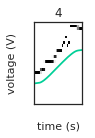

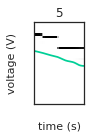

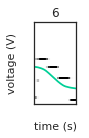

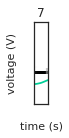

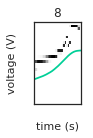

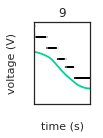

In [11]:
npl.plot(pos_example1, color='k', label='actual position')
plt.show()

for ii in range(st_example1.n_epochs):
    bst_snippet = st_example1[ii].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=round(ds_run/ds_50ms))
    posterior = hmm.predict_proba(bst_snippet)

    fig, ax = plt.subplots(figsize=(bst_snippet.n_bins/36, 1.5))
    ax, img = npl.imagesc(x=bst_snippet.bin_centers, y=np.linspace(0,310, num=30), data=posterior)
    npl.utils.no_ticks()
    npl.utils.no_xticklabels()
    npl.utils.no_yticklabels()
    ax.set_title(ii)
    npl.plot(pos_example1[ii], ax=ax)

    plt.show()

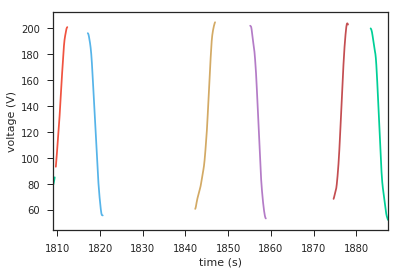

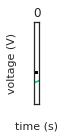

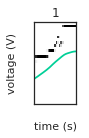

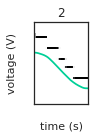

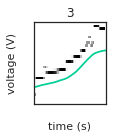

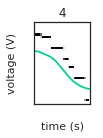

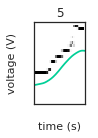

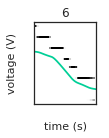

In [12]:
npl.plot(pos_example2)
plt.show()

for ii in range(st_example2.n_epochs):
    bst_snippet = st_example2[ii].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=round(ds_run/ds_50ms))
    posterior = hmm.predict_proba(bst_snippet)

    fig, ax = plt.subplots(figsize=(bst_snippet.n_bins/36, 1.5))
    ax, img = npl.imagesc(x=bst_snippet.bin_centers, y=np.linspace(0,310, num=30), data=posterior)
    npl.utils.no_ticks()
    npl.utils.no_xticklabels()
    npl.utils.no_yticklabels()
    ax.set_title(ii)
    npl.plot(pos_example2[ii], ax=ax)

    plt.show()
#     npl.savefig('example-snippet-' + str(ii), fig=fig, formats=['pdf', 'png', 'svg'])

In [13]:
min_tc_duration = 0
sigma_tc = 4

lsPF = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
lsPF = lsPF.smooth(sigma=sigma_tc)

states_in_track_order = np.array(lsPF.get_peak_firing_order_ids())-1

lsPF.reorder_units(inplace=True)

<TuningCurve1D at 0x1ce49763198> with shape (30, 124)

In [14]:
posterior_pos, bdries, mode_pth, mean_pth = hmm.decode_ext(bst_example1, ext_shape=(lsPF.n_bins,))
mean_pth = lsPF.bins[0] + mean_pth*(lsPF.bins[-1] - lsPF.bins[0])
posterior = hmm.predict_proba(bst_example1)

Text(0,0.5,'state')

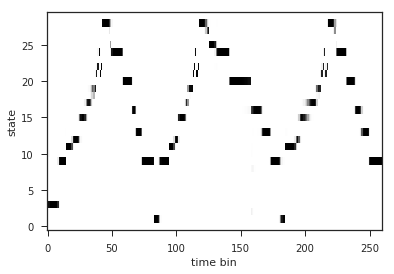

In [15]:
npl.imagesc(posterior)
plt.xlabel('time bin')
plt.ylabel('state')

In [16]:
tvals, target = pos.asarray(at=bst_example1.bin_centers)
target_asa = nel.AnalogSignalArray(ydata=target, timestamps=tvals)
decoded_asa = nel.AnalogSignalArray(ydata=np.atleast_2d(mean_pth), timestamps=tvals)

Text(0,0.5,'position (cm)')

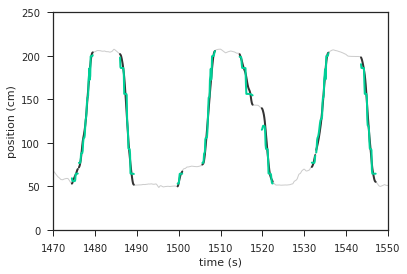

In [17]:
npl.plot(pos, color='0.8', lw=1, label='true position')
npl.plot(target_asa, color='0.2', lw=2, label='true position during RUN')
npl.plot(decoded_asa, color=npl.colors.sweet.green, lw=2, label='decoded')
ax = plt.gca()
ax.set_xlim(1470,1550)
ax.set_ylim(0,250)
# plt.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('position (cm)')
# npl.savefig('run_dec_example', formats=['pdf','png', 'svg'])

Text(0,0.5,'state')

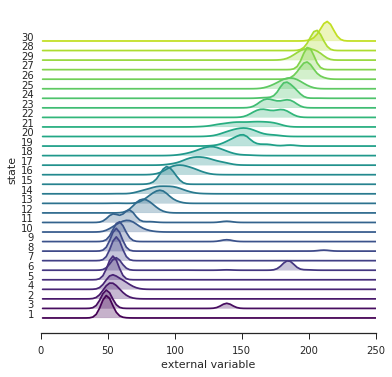

In [18]:
NUM_COLORS = lsPF.n_units + 2

cm = plt.get_cmap('viridis')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

npl.set_palette(clist)

fig, axs = plt.subplots(1,1,figsize=(6,6))
npl.plot_tuning_curves1D(lsPF, pad=0.1, ax=axs)
axs.set_xlim(0, 250)
axs.set_ylabel('state')


(0, 250)

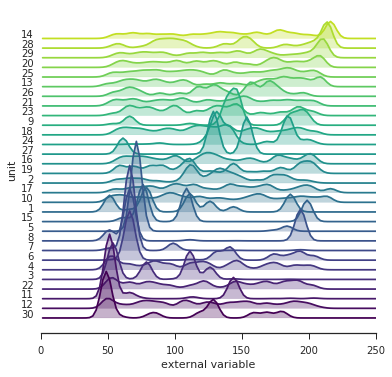

In [19]:
import copy

shuffled_pos = copy.deepcopy(pos)

# shuffled_pos._interp = None # necessary so that new interpolant is used, and not old one, before shuffle
xpos = shuffled_pos.asarray(at=bst_run_no_mua.centers).yvals
xpos = xpos[np.random.permutation(len(xpos))]

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_run_no_mua, ext=ext_x, n_extern=ext_nx)
# transform into ratemap shape

vtc_shfl = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
vtc_shfl = vtc_shfl.smooth(sigma=sigma_tc)

vtc_shfl.reorder_units(inplace=True)

# normalize position distributions for each state (FFB! This will affect decoding! But it's not the only "correct" way to normalize!)
vtc_shfl._ratemap = (vtc_shfl.ratemap.T / vtc_shfl.ratemap.sum(axis=1)).T

fig, axs = plt.subplots(1,1,figsize=(6,6))
ax = npl.plot_tuning_curves1D(vtc_shfl, normalize=False, pad=0.025)
ax.set_xlim(0, 250)

# npl.savefig('vtc_shuffled_new_noIN4', formats=['pdf', 'png', 'svg'], overwrite=True)